# Neo4J Import and Queries

In [1]:
pip install neo4j==4.4.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for neo4j: filename=neo4j-4.4.11-py3-none-any.whl size=111249 sha256=09a7d378d5834992ff9ec805da8e57bdeb0b3b72a8347c31cf650024fdc1274d
  Stored in directory: /home/jovyan/.cache/pip/wheels/9b/29/51/cd9c7f08102e1afefd87d7307e45556c08f51eec519f2e6e05
Successfully built neo4j
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import random
import csv

## Aufbau der Datenbankverbindung

In [3]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

Der Variablen "conn" sollte der LEADER-Knoten zugewiesen werden, der WRITE-Rechte hat.
Um herauszufinden, welcher Knoten der LEADER-Knoten ist, sollte zu der Webkonsole eines Knotens unter http://localhost:7474 verbunden werden und dann der Befehl ":sysinfo" ausgeführt werden. 

Es sollte eine Tabelle folgender Art erscheinen:

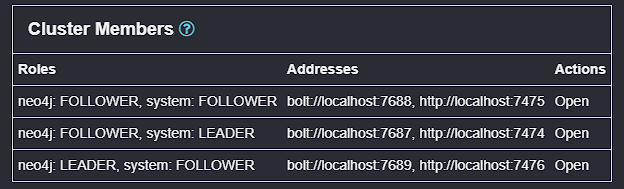


core1: bolt://localhost:7687, http://localhost:7474
core2: bolt://localhost:7688, http://localhost:7475
core3: bolt://localhost:7689, http://localhost:7476

Der Knoten, beim dem "neo4j:LEADER" steht, sollte unten eingetragen werden. Als Port wird allerdings immer "7687" auf der Host-Maschine verwendet.

In [4]:
conn = Neo4jConnection(uri="bolt://core3:7687", user="neo4j", pwd="password")
secondConn = Neo4jConnection(uri="bolt://core2:7687", user="neo4j", pwd="password")

In [5]:
print(conn.query(f"MATCH (n) RETURN n LIMIT 1;"))

print(secondConn.query(f"MATCH (n) RETURN n LIMIT 1;"))

[]
[]


## Importieren der Knoten und Beziehungen

### Einlesen des "twitter_combined" Files

In [6]:
follows_file = open('twitter_combined.txt', 'r')
lines = follows_file.readlines()

follows = []
users = set()
for line in lines:
    line = line.replace('\n','')
    id1, id2 = line.split(' ')
    users.add(id1)
    users.add(id2)
    follows.append([id1, id2])

### Erstellung des CSV Files für den Import der User

In [7]:
count = 0
f = open("import/users.csv", "w")
f.write("userId,name,:Label\n")
for user in users:
    f.write(user + ",user" + str(count) + ",USER\n")
    count += 1
f.close()

### Importieren der User

In [8]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///users.csv' AS row CREATE (:User {userId: row.userId, name: row.name})")
conn.query("CREATE CONSTRAINT user_constraint IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE")

CPU times: user 2.83 ms, sys: 641 µs, total: 3.47 ms
Wall time: 6.05 s


[]

In [9]:
print(conn.query("MATCH(u: User) return u LIMIT 10"));
print(secondConn.query("MATCH(u: User) return u LIMIT 10"))

[<Record u=<Node id=0 labels=frozenset({'User'}) properties={'name': 'user0', 'userId': '182685687'}>>, <Record u=<Node id=1 labels=frozenset({'User'}) properties={'name': 'user1', 'userId': '69949683'}>>, <Record u=<Node id=2 labels=frozenset({'User'}) properties={'name': 'user2', 'userId': '4981271'}>>, <Record u=<Node id=3 labels=frozenset({'User'}) properties={'name': 'user3', 'userId': '375342331'}>>, <Record u=<Node id=4 labels=frozenset({'User'}) properties={'name': 'user4', 'userId': '18320606'}>>, <Record u=<Node id=5 labels=frozenset({'User'}) properties={'name': 'user5', 'userId': '52651072'}>>, <Record u=<Node id=6 labels=frozenset({'User'}) properties={'name': 'user6', 'userId': '229195612'}>>, <Record u=<Node id=7 labels=frozenset({'User'}) properties={'name': 'user7', 'userId': '14512689'}>>, <Record u=<Node id=8 labels=frozenset({'User'}) properties={'name': 'user8', 'userId': '17483462'}>>, <Record u=<Node id=9 labels=frozenset({'User'}) properties={'name': 'user9', 'u

### Erstellung des CSV Files für den Import der Tweets anhand des "tweets" CSV Files 

In [10]:
tweets = pd.read_csv("tweets.csv")
f = open("import/tweetsDB.csv", "w")
writer = csv.writer(f)
writer.writerow(["tweetId","content","date_time","language",":Label"])
count = 1
for index, tweet in tweets.iterrows():
    writer.writerow([count,tweet["content"],tweet["date_time"],tweet["language"],"TWEET"])
    count += 1
f.close()

### Importieren der Tweets

In [11]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///tweetsDB.csv' AS row CREATE (:Tweet {tweetId: row.tweetId, content: row.content, date_time: row.date_time, language: row.language})")
conn.query("CREATE CONSTRAINT tweet_constraint IF NOT EXISTS FOR (t:Tweet) REQUIRE t.tweetId IS UNIQUE")

CPU times: user 2.92 ms, sys: 500 µs, total: 3.42 ms
Wall time: 4.15 s


[]

### Erstellung des CSV Files für den Import der FOLLOWS-Beziehung

In [12]:
f = open("import/follows.csv", "w")
f.write("userId,followerId,:TYPE\n")
for follow in follows:
    f.write(follow[0] + "," + follow[1] + ",FOLLOWS\n")
f.close()

### Import der FOLLOWS-Beziehungen

In [13]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///follows.csv' AS row MATCH (e:User {userId: row.userId}) MATCH (c:User {userId: row.followerId}) MERGE (e)-[:FOLLOWS]->(c)")

CPU times: user 4.3 ms, sys: 648 µs, total: 4.95 ms
Wall time: 1min 2s


[]

### Erstellung des CSV Files für den Import der POSTED-Beziehung
Jeder der Tweets wird zufällig auf einen der 100 User mit den meisten Followern verteilt.

In [14]:
top100 = conn.query("MATCH (a)-[:FOLLOWS]->(b) RETURN b, COUNT(a) as followers ORDER BY followers DESC LIMIT 100")

In [15]:
user_ids = []
for record in top100:
    user_ids.append(record.get("b").get("userId"))

tweets = pd.read_csv("import/tweetsDB.csv")
f = open("import/posted.csv", "w")
f.write("userId,tweetId,:TYPE\n")
for index, tweet in tweets.iterrows():
    f.write(f'{random.choice(user_ids)},{tweet["tweetId"]},POSTED\n')
f.close()

### Import der POSTED-Beziehungen

In [16]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///posted.csv' AS row MATCH (u:User {userId: row.userId}) MATCH (t:Tweet {tweetId: row.tweetId}) MERGE (u)-[:POSTED]->(t)")

CPU times: user 0 ns, sys: 3 ms, total: 3 ms
Wall time: 2.41 s


[]

### Erstellung des CSV Files für den Import der LIKES-Beziehung
Für jeden Tweet werden aus den Followern des Posters etwa 10 % ausgewählt, welche des Post liken. Die Like-Zahlen aus dem "tweets" CSV File werden dabei nicht berücksichtigt.

In [17]:
allTweets = conn.query("Match (t: Tweet) RETURN t");
f = open("import/likes.csv","w")
f.write("userId,tweetId,:TYPE\n")

for user in top100: 
    followers = conn.query(f"MATCH (follower:User)-[:FOLLOWS]->(following:User) WHERE following.userId ='{user['b']['userId']}' RETURN follower")
    tweets = conn.query(f"MATCH (u:User {{userId: '{user['b']['userId']}'}})-[:POSTED]->(t:Tweet) RETURN t");
    for tweet in tweets: 
        for follower in followers:
            shouldLike = random.random() < 0.1
            if shouldLike:
                f.write(f"{follower['follower']['userId']},{tweet['t']['tweetId']},LIKES\n")

f.close()    

### Import der LIKES-Beziehungen

In [18]:
%%time
conn.query("LOAD CSV WITH HEADERS FROM 'file:///likes.csv' as row CALL { with row MATCH (u:User {userId: row.userId}) MATCH (t:Tweet {tweetId: row.tweetId}) MERGE (u)-[:LIKES]->(t) }  IN TRANSACTIONS OF 100000 ROWS")

CPU times: user 9.75 ms, sys: 158 µs, total: 9.91 ms
Wall time: 3min 20s


[]

## Queries

### 1. Alle Posts eines zufälligen Users

In [19]:
random_poster = random.choice(top100)

result = conn.query(f"MATCH (u:User {{name: '{random_poster['b']['name']}'}})-[:POSTED]->(t:Tweet) RETURN t")
for tweet in result:
    print(tweet['t']['content'])
    print("")

@bellathorne 😘

My fav combo of ppl all in one pic, I only roll with world changers❗️ https://t.co/oH37gAsO7c

Which pie will Pizza Rat love most? https://t.co/xaYr5iDFLv https://t.co/srWMeTbdQP

I keep hiding things in secret spots in my apartment and then forgetting where I hid them. Would've been the worst pirate ever.

.@TeamCoco comes to YouTube to try VR. 

Hilarity ensues. https://t.co/xoeUJgQXtv https://t.co/GCBtC9De2k

I was really looking forward to the amazing #iHeartRadio Music Festival, but will see you guys soon! Shak

Hi! #SINGAPORE http://t.co/lCrxNPoZJa

Say cheese. #NationalPizzaDay https://t.co/cqNblFDAta

Portugal 3 - Iceland 1

#IceBucketChallenge #ALS #SharePainShowCompassion I nominate Adele, Michael Rapino, Vincent Herbert,… http://t.co/BdK8IWIogV

@PhilTBH THATS THE BIGGEST COMPLIMENT AND HONOR EVER

"@MikaylaRagovin: @jtimberlake maybe next time you can qualify for the Olympics ;)." If they have some sort of eating event, I'm in.

Thank u https://t.co/4I3agAJz

### 2. Top 100 User mit den meisten Followern

In [20]:
top100 = conn.query("MATCH (a)-[:FOLLOWS]->(b) RETURN b, COUNT(a) as followers ORDER BY followers DESC LIMIT 100")

for user in top100:
    print(user['b']['name'], "hat", user['followers'], "Follower")

user40479 hat 3383 Follower
user48333 hat 3216 Follower
user73684 hat 2735 Follower
user2836 hat 2647 Follower
user44584 hat 2471 Follower
user61505 hat 2462 Follower
user37728 hat 2133 Follower
user44039 hat 2074 Follower
user23732 hat 1905 Follower
user70466 hat 1707 Follower
user11895 hat 1632 Follower
user18519 hat 1591 Follower
user68179 hat 1521 Follower
user37771 hat 1503 Follower
user31700 hat 1500 Follower
user67373 hat 1410 Follower
user15246 hat 1402 Follower
user37129 hat 1370 Follower
user63997 hat 1337 Follower
user20616 hat 1315 Follower
user5280 hat 1273 Follower
user19362 hat 1255 Follower
user21546 hat 1231 Follower
user61825 hat 1214 Follower
user52774 hat 1201 Follower
user35595 hat 1198 Follower
user20339 hat 1186 Follower
user65655 hat 1167 Follower
user23706 hat 1154 Follower
user46096 hat 1123 Follower
user55858 hat 1120 Follower
user57809 hat 1108 Follower
user77072 hat 1098 Follower
user72061 hat 1088 Follower
user80745 hat 1072 Follower
user49738 hat 1070 Fol

### 3. Top 100 User, die den meisten Usern der Top 100 folgen

In [21]:
query = """MATCH (follower:User)-[follows:FOLLOWS]->(followed:User)
WHERE followed.userId IN [""" 

count = 0
for user in top100:
    query += f"'{user['b']['userId']}'"
    if count < 99: query += ","
    count += 1

query += """]
WITH follower, COUNT(follows) AS numFollowed
ORDER BY numFollowed DESC
RETURN follower.name AS username, numFollowed
LIMIT 100
"""

result = conn.query(query)

In [22]:
for record in result:
    print(record['username'], "folgt", record['numFollowed'], 'Usern')

user23732 folgt 69 Usern
user24603 folgt 55 Usern
user81153 folgt 50 Usern
user16737 folgt 49 Usern
user77072 folgt 47 Usern
user59542 folgt 46 Usern
user29933 folgt 44 Usern
user69871 folgt 41 Usern
user4315 folgt 40 Usern
user38984 folgt 39 Usern
user24554 folgt 38 Usern
user39911 folgt 38 Usern
user80207 folgt 37 Usern
user48765 folgt 37 Usern
user35175 folgt 37 Usern
user10433 folgt 36 Usern
user64163 folgt 35 Usern
user55911 folgt 35 Usern
user45513 folgt 35 Usern
user18488 folgt 35 Usern
user7294 folgt 34 Usern
user73842 folgt 34 Usern
user35441 folgt 34 Usern
user14538 folgt 34 Usern
user45454 folgt 34 Usern
user62122 folgt 34 Usern
user61272 folgt 33 Usern
user13983 folgt 33 Usern
user18519 folgt 33 Usern
user18062 folgt 33 Usern
user57625 folgt 31 Usern
user5684 folgt 31 Usern
user6322 folgt 31 Usern
user69443 folgt 31 Usern
user55284 folgt 31 Usern
user17230 folgt 30 Usern
user52774 folgt 30 Usern
user58949 folgt 30 Usern
user17733 folgt 30 Usern
user49851 folgt 30 Usern
user

### 4. Informationen für persönliche Startseite eines zufälligen Users (der Top 100 mit den meisten Followern)

In [23]:
random_user = random.choice(top100)

#### 1. Anzahl der Follower

In [24]:
result = conn.query(f"MATCH (follower:User)-[:FOLLOWS]->(user:User {{name: '{random_user['b']['name']}'}}) RETURN count(follower) AS followerCount")
print(result[0]['followerCount'])

844


#### 2. Anzahl der verfolgten Accounts

In [25]:
result = conn.query(f"MATCH (user:User {{name: '{random_user['b']['name']}'}})-[:FOLLOWS]->(followed:User) RETURN count(followed) AS followedCount")
print(result[0]['followedCount'])

41


#### 3.1 Die 25 meistgeliketen Posts der verfolgten Accounts

In [26]:
result = conn.query(f"""
MATCH (follower:User)-[:FOLLOWS]->(followed:User)-[:POSTED]->(tweet:Tweet)
WHERE follower.name = '{random_user['b']['name']}'
WITH follower, collect(followed.name) AS followedUsers
MATCH (t:Tweet)<-[:POSTED]-(u:User)
WHERE u.name IN followedUsers
OPTIONAL MATCH (t)<-[:LIKES]-(liker:User)
RETURN t.content AS content, COUNT(liker) AS numLikes
ORDER BY numLikes DESC
LIMIT 25
""")

for tweet in result:
    print(tweet['content'])
    print("Likes: ", tweet['numLikes'])
    print()

Who is coming? @Skrillex http://t.co/mUGI75XnJy
Likes:  240

Do you remember? Last month, @SFR surprised me.Well, it happened again, the experience was amazing! #CristianoAndSFR https://t.co/M89vkGLonp
Likes:  232

babes, post cards will be back in stock tomorrow 10am pst / 1pm est.... https://t.co/vpJNVa2Hzt you are insane and amazing and i love you.
Likes:  226

Interviews are done months and months before the issue is published. I lot can change between then and now. Don't read into the bullshit
Likes:  226

You're a day late @SimonCowell. Clearly your senility is to blame. I forgive you :)
Likes:  222

I'm delighted to become the official ambassador of @XTrade . Join me! https://t.co/zjThlQN14M  #XTrade https://t.co/pAeI15Xs2f
Likes:  219

Thank you @sportmad18 Well done @Cristiano scoring 50 La Liga goals in 51 matches. No RM player has needed fewer matches to reach milestone
Likes:  219

@angelfordelena @Spotify I write songs in bathrooms most. Haha
Likes:  219

SEASON 12 @KUWTK 

#### 3.2 Die 25 neuesten Posts der verfolgten Accounts

In [27]:
result = conn.query(f"""
MATCH (follower:User)-[:FOLLOWS]->(followed:User)-[:POSTED]->(tweet:Tweet)
WHERE follower.name = '{random_user['b']['name']}'
WITH follower, collect(followed.name) AS followedUsers
MATCH (t:Tweet)<-[:POSTED]-(u:User)
WHERE u.name IN followedUsers
RETURN t.content AS content, t.date_time AS date
ORDER BY t.date_time DESC
LIMIT 25
""")

for tweet in result:
    print(tweet['content'])
    print("Getweeted am: ", tweet['date'])
    print()

“To sit back and let fate play its hand out and never influence it is not the way man was meant to operate.” https://t.co/U7cUApqcz7
Getweeted am:  31/12/2016 23:30

Quién ha incluido Chantaje en su playlist de @Spotify de fin de año? Nos indican dónde van a celebrarlo? https://t.co/EAtARlrG6F ShakHQ
Getweeted am:  31/12/2016 14:53

Who's got Chantaje on their @Spotify NYE playlist for tonight? Let us know where you’re partying! ShakHQ https://t.co/EAtARlrG6F
Getweeted am:  31/12/2016 14:51

You don't want to miss this. Say you'll tune in for President Obama's final #SOTU: https://t.co/0nLa9bR8wb https://t.co/JkidFquqS7
Getweeted am:  31/12/2015 23:25

grateful and excited. thank you to my babes for making 2015 so special. I love you I love you sfm. happy New Year's Eve!!!!!!!!!!!!!!!!!!! ✨
Getweeted am:  31/12/2015 19:25

You and a friend could be heading north. Enter now to win a cruise to Alaska: https://t.co/R3Zhuc2Jt4 https://t.co/P8NjsWwpAg
Getweeted am:  31/12/2015 18:15

Watch 

#### 4. Erstellung eines neuen Posts: Herstellen einer Caching-Beziehung bei allen Followern

In [28]:
num_tweets = conn.query("MATCH (t:Tweet) RETURN COUNT(t)")[0]['COUNT(t)']
print(num_tweets)

52542


In [29]:
tweet = {
    "tweetId": str(num_tweets+1),
    "content": "Doing neo4j queries right now #BDEA",
    "date_time": "18/06/2023 09:48",
    "language": "en"
}

##### Tweet importieren

In [30]:
new_tweet = conn.query(f"CREATE (t:Tweet {{tweetId: '{tweet['tweetId']}', content: '{tweet['content']}', date_time: '{tweet['date_time']}', language: '{tweet['language']}'}}) RETURN t")

In [31]:
print(new_tweet)

[<Record t=<Node id=133848 labels=frozenset({'Tweet'}) properties={'date_time': '18/06/2023 09:48', 'language': 'en', 'tweetId': '52543', 'content': 'Doing neo4j queries right now #BDEA'}>>]


##### POSTED-Beziehung herstellen

In [32]:
conn.query(f"MATCH (user:User {{userId: '{random_user['b']['userId']}'}}) MATCH (tweet:Tweet {{tweetId: '{new_tweet[0]['t']['tweetId']}'}}) CREATE (user)-[:POSTED]->(tweet)")

[]

##### CACHED-Beziehung bei allen Followern des Posters herstellen

In [33]:
followers = conn.query(f"MATCH (follower:User)-[:FOLLOWS]->(user:User {{userId: '{random_user['b']['userId']}'}}) RETURN follower")
print(len(followers))

844


In [34]:
print(random_user['b']['userId'])

18742444


In [35]:
for follower in followers:
    conn.query(f"MATCH (user:User {{userId: '{follower['follower']['userId']}'}}) MATCH (tweet:Tweet {{tweetId: '{new_tweet[0]['t']['tweetId']}'}}) CREATE (user)-[:CACHED]->(tweet)")

##### Check how many users have the tweet cached (should be the same as number followers)

In [36]:
conn.query("MATCH (u:User)-[r:CACHED]->(tweet:Tweet {tweetId: '52543'}) RETURN COUNT(u)")

[<Record COUNT(u)=844>]

#### 5. Die 25 beliebtesten Tweets, welche die Wörter "hello" und "from" enthalten

In [37]:
result = conn.query("""
MATCH (t:Tweet)
WHERE ALL(word IN [' hello ', ' from '] WHERE t.content CONTAINS word)
WITH t
MATCH (t)<-[:LIKES]-(liker:User)
RETURN t.content AS content, COUNT(liker) AS numLikes
ORDER BY numLikes DESC
LIMIT 25
""")

for tweet in result:
    print(tweet['content'])
    print("Likes: ", tweet['numLikes'])
    print()

You asked: hello from France, champion ! :) im so proud of you http://t.co/AhDl5iMGzF
Likes:  207

#JoanneVibes say hello from backstage at...??? https://t.co/m9PI2oUUo8
Likes:  168

Say hello to Himanshu Yadav and all my friends from #India. I will come shortly with more news. http://t.co/60xEW67c
Likes:  119

You asked: Can you say hello to me?  My name is Narin and I am from Germany http://t.co/lx2CRb3xwh
Likes:  102

You asked: Hi Ronaldo! I love you so much! Please say hello to me! I am from Turkey!  http://t.co/xpDH5Ppb67
Likes:  94

You asked: hello from morocco 
 http://t.co/gbuEyP5953
Likes:  79

Why did @Adele cross the road? She wanted to say hello from the other side.
Likes:  76

You asked: Can you say hello to me ,please? I am from Bulgaria!!! http://t.co/dyNj55sAq4
Likes:  74

You asked: 
Hello from Japan!
I'm Anna!I I'm a big fan! Please say me hello Anna!
 http://t.co/5Oyi7SiUhY
Likes:  68

